In [ ]:
pip install opencv-python numpy csv

ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv


In [ ]:
!pip install opencv-contrib-python

In [ ]:
!pip install dlib
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2025-03-25 09:01:11--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 [following]
--2025-03-25 09:01:11--  https://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Connecting to dlib.net (dlib.net)|107.180.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  35.0MB/s    in 1.7s    

2025-03-25 09:01:13 (35.0 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
pip install qrcode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import os
import csv
import qrcode
import random
from datetime import datetime, timedelta
import pytz
from PIL import Image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode
import dlib
from scipy.spatial import distance
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# ----------
# Webcam Setup (Colab-specific)
# ----------
def take_photo_burst(num_frames=3, delay=500, quality=0.7):
    js = Javascript('''
    async function takeBurst(num, delay, quality) {
        const div = document.createElement('div');
        const btn = document.createElement('button');
        btn.textContent = 'Capture';
        div.appendChild(btn);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight);
        await new Promise(resolve => btn.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        const ctx = canvas.getContext('2d');

        const frames = [];
        for(let i=0; i<num; i++) {
            ctx.drawImage(video, 0, 0);
            frames.push(canvas.toDataURL('image/jpeg', quality));
            await new Promise(resolve => setTimeout(resolve, delay));
        }

        stream.getTracks().forEach(track => track.stop());
        div.remove();
        return frames;
    }
    ''')

    display(js)
    data = eval_js(f'takeBurst({num_frames}, {delay}, {quality})')
    return [b64decode(f.split(',')[1]) for f in data]

In [ ]:
# ----------
# Liveness Detection
# ----------
class BlinkDetector:
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        self.EYE_AR_THRESH = 0.5
        self.EYE_AR_CONSEC_FRAMES = 1

    @staticmethod
    def eye_aspect_ratio(eye):
        A = distance.euclidean(eye[1], eye[5])
        B = distance.euclidean(eye[2], eye[4])
        C = distance.euclidean(eye[0], eye[3])
        return (A + B) / (2.0 * C)

    def detect(self, frames):
        max_blinks = 0
        current_blinks = 0

        for frame_data in frames:
            img_np = np.frombuffer(frame_data, np.uint8)
            frame = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
            if frame is None:
                continue

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = self.detector(gray, 0)

            for face in faces:
                shape = self.predictor(gray, face)
                shape = np.array([(shape.part(i).x, shape.part(i).y) for i in range(68)])

                try:
                    left_eye = shape[42:48]
                    right_eye = shape[36:42]
                    ear = (self.eye_aspect_ratio(left_eye) + self.eye_aspect_ratio(right_eye)) / 2.0

                    if ear < self.EYE_AR_THRESH:
                        current_blinks += 1
                        max_blinks = max(max_blinks, current_blinks)
                    else:
                        current_blinks = 0

                except Exception as e:
                    print(f"Eye detection error: {str(e)}")

        return max_blinks >= self.EYE_AR_CONSEC_FRAMES

# ----------
# Face Recognition System
# ----------
class AttendanceSystem:
    def __init__(self):
        self.face_detector = YOLO("yolov8n.pt")  #YOLO-----------------------------------------------------
        self.face_recognizer = cv2.face.LBPHFaceRecognizer_create()
        self.dataset_dir = "dataset"
        self.registered_names = []
        self.blink_detector = BlinkDetector()
        self.logged_in_users = {}  # Track active users {name: next_qr_time}

        os.makedirs(self.dataset_dir, exist_ok=True)
        if os.path.exists("registered_names.npy"):
            self.registered_names = np.load("registered_names.npy", allow_pickle=True).tolist()

    def register_face(self):
        name = input("Enter your name: ").strip()
        if name in self.registered_names:
            print(f"{name} already registered!")
            return

        print("Look at the camera and blink normally...")
        frames = take_photo_burst(num_frames=5, delay=500)
        if len(frames) < 5:
            print("Registration failed - could not capture enough frames")
            return

        # Check if only one face is present in all frames
        for frame_data in frames:
            img_np = np.frombuffer(frame_data, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
            results = self.face_detector(img)
            faces = results[0].boxes.xyxy.cpu().numpy()

            if len(faces) != 1:
                print("Registration failed - Only one person should be in the frame.")
                return

        face_samples = []
        for i, frame_data in enumerate(frames):
            img_np = np.frombuffer(frame_data, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            results = self.face_detector(img)
            faces = results[0].boxes.xyxy.cpu().numpy()

            if len(faces) == 0:
                print(f"Frame {i+1}: No face detected")
                continue

            (x1, y1, x2, y2) = map(int, faces[0])
            face_roi = gray[y1:y2, x1:x2]
            face_samples.append(face_roi)

            cv2.imwrite(f"{self.dataset_dir}/{name}_{i}.jpg", face_roi)

        if len(face_samples) < 3:
            print("Registration failed - insufficient valid samples")
            return

        self.registered_names.append(name)
        np.save("registered_names.npy", self.registered_names)
        self.train_model()
        print(f"{name} registered successfully!")

    def train_model(self):
        faces, labels = [], []
        for label, name in enumerate(self.registered_names):
            for img_file in os.listdir(self.dataset_dir):
                if img_file.startswith(name):
                    img_path = os.path.join(self.dataset_dir, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        faces.append(img)
                        labels.append(label)

        if len(faces) > 0:
            self.face_recognizer.train(faces, np.array(labels))
            self.face_recognizer.save("trained_model.yml")
            print("Model updated with new registrations")

    def recognize_face(self):
        if not os.path.exists("trained_model.yml"):
            print("No trained model found!")
            return

        self.face_recognizer.read("trained_model.yml")
        print("Look at the camera and blink normally for verification...")
        frames = take_photo_burst()
        if not frames:
            print("No frames captured")
            return

        # Check if only one face is present in all frames
        for frame_data in frames:
            img_np = np.frombuffer(frame_data, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
            results = self.face_detector(img)

            person_detections = []
            for result in results:
                for box in result.boxes:
                    if int(box.cls) == 0:
                        person_detections.append(box.xyxy.cpu().numpy())
            if len(person_detections) != 1:
                print("Attendance logging failed - Only one person should be in the frame.")
                return

        if not self.blink_detector.detect(frames):
            print("Liveness check failed - no blink detected")
            return

        img_np = np.frombuffer(frames[0], np.uint8)
        img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        results = self.face_detector(img)

        # Filter only "person" class detections
        person_detections = []
        for result in results:
            for box in result.boxes:
                if int(box.cls) == 0:  # Class 0 is "person" in YOLOv8
                    person_detections.append(box.xyxy.cpu().numpy())

        for detection in person_detections:
            (x1, y1, x2, y2) = map(int, detection[0])
            face_roi = gray[y1:y2, x1:x2]
            label, confidence = self.face_recognizer.predict(face_roi)

            if confidence < 60:
                name = self.registered_names[label]
                self.log_attendance(name, "Log In")
                cv2.putText(img, name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
            else:
                cv2.putText(img, "Unknown", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

        cv2_imshow(img)

    def log_off(self):
        frames = take_photo_burst()
        if not frames:
            print("No frames captured")
            return

        if not self.blink_detector.detect(frames):
            print("Liveness check failed - no blink detected")
            return

        # Check if only one face is present in all frames
        for frame_data in frames:
            img_np = np.frombuffer(frame_data, np.uint8)
            img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
            results = self.face_detector(img)
            faces = results[0].boxes.xyxy.cpu().numpy()

            if len(faces) != 1:
                print("Log off failed - Only one person should be in the frame.")
                return

        img_np = np.frombuffer(frames[0], np.uint8)
        img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        results = self.face_detector(img)
        faces = results[0].boxes.xyxy.cpu().numpy()

        if not os.path.exists("trained_model.yml"):
            print("No trained model found. Please register a face first.")
            return

        self.face_recognizer.read("trained_model.yml")

        for (x1, y1, x2, y2) in faces:
            face_roi = gray[int(y1):int(y2), int(x1):int(x2)]
            label, confidence = self.face_recognizer.predict(face_roi)

            if confidence < 60:
                name = self.registered_names[label]
                self.log_attendance(name, "Log Off")
                cv2.putText(img, name, (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
            else:
                cv2.putText(img, "Unknown", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)

            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0,255,0), 2)

        cv2_imshow(img)

    def check_and_generate_qr_codes(self):
        now = datetime.now(pytz.timezone('Asia/Karachi'))

        for name in list(self.logged_in_users.keys()):  # Safe iteration
            user_data = self.logged_in_users.get(name)
            if not user_data:
                continue

            if now >= user_data['next_qr_time']:
                # Generate QR code
                qr = qrcode.QRCode(
                    version=1,
                    error_correction=qrcode.constants.ERROR_CORRECT_L,
                    box_size=10,
                    border=4,
                )
                qr_data = f"{name}-{now.strftime('%Y-%m-%d-%H-%M-%S')}"
                qr.add_data(qr_data)
                qr.make(fit=True)

                # Create and display QR code
                img = qr.make_image(fill_color="black", back_color="white")
                img_np = np.array(img.convert('RGB'))
                img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

                print(f"\n🚨 ALERT: {name}, verify your presence! 🚨")
                cv2_imshow(img_np)

                # Update next check time (2 hours from now)
                self.logged_in_users[name]['next_qr_time'] = now + timedelta(hours=2)
                img.save(f"qr_{name}_{now.strftime('%Y%m%d%H%M')}.png")

    def log_attendance(self, name, action):
        now = datetime.now(pytz.timezone('Asia/Karachi'))
        date_str = now.strftime("%Y-%m-%d")
        time_str = now.strftime("%H:%M:%S")

        entries = []
        if os.path.exists("attendance.csv"):
            with open("attendance.csv", "r") as f:
                reader = csv.reader(f)
                entries = list(reader)

        last_action = None
        for entry in reversed(entries):
            if entry[0] == name and entry[1] == date_str:
                last_action = entry[3]
                break

        if action == "Log In":
            initial_delay = random.randint(0, 1)  # Minutes
            self.logged_in_users[name] = {
                'next_qr_time': now + timedelta(minutes=initial_delay)
            }
        elif action == "Log Off":
            if name in self.logged_in_users:
                del self.logged_in_users[name]

        if action == "Log Off" and (last_action != "Log In" or last_action == "Log Off"):
            print(f"{name} must log in before logging out!")
            return

        with open("attendance.csv", "a", newline="") as f:
            writer = csv.writer(f)
            writer.writerow([name, date_str, time_str, action])
        print(f"Attendance logged: {name} {action} at {time_str}")


1. Register Face
2. Log In
3. Log Off
4. Exit
Select option: 2
Look at the camera and blink normally for verification...


<IPython.core.display.Javascript object>


0: 480x640 1 person, 1 tv, 225.2ms
Speed: 4.2ms preprocess, 225.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 187.2ms
Speed: 3.4ms preprocess, 187.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 187.8ms
Speed: 3.0ms preprocess, 187.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tv, 190.9ms
Speed: 3.2ms preprocess, 190.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
Attendance logged: Hassan Log In at 14:38:30


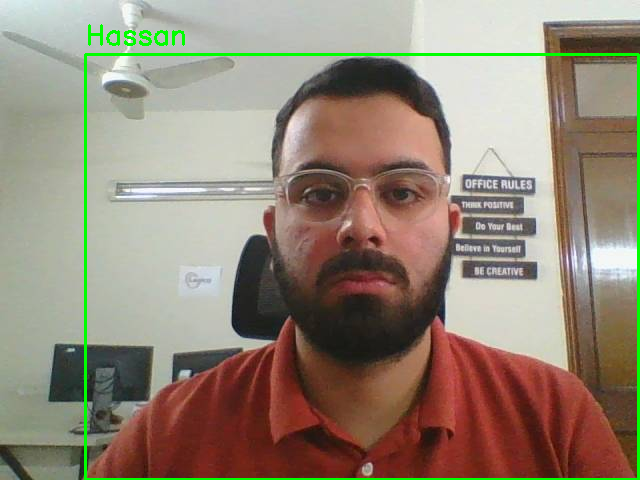


1. Register Face
2. Log In
3. Log Off
4. Exit

🚨 ALERT: Hassan, verify your presence! 🚨


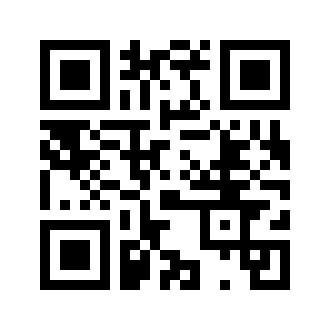

Select option: 4


In [ ]:
# ----------
# Main Program
# ----------
if __name__ == "__main__":
    system = AttendanceSystem()

    while True:
        print("\n1. Register Face\n2. Log In\n3. Log Off\n4. Exit")
        system.check_and_generate_qr_codes()
        choice = input("Select option: ").strip()

        if choice == '1':
            system.register_face()
        elif choice == '2':
            system.recognize_face()
        elif choice == '3':
            system.log_off()
        elif choice == '4':
            break
        else:
            print("Invalid choice!")